In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import re
import string
print(string.punctuation)
#pd.options.display.max_rows = None
pd.options.display.max_columns = 100

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [2]:
import nltk
nltk.__version__

'3.4.5'

In [3]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
data = pd.read_csv('tweet-sentiment-extraction/sample_submission.csv')
test = pd.read_csv('tweet-sentiment-extraction/test.csv')
train = pd.read_csv('tweet-sentiment-extraction/train.csv',encoding='utf-8-sig')

In [5]:
display(test.head(1))
print(test.shape)
print(test.isnull().sum())
display(train.tail(1))
print(train.shape)
print(train.isnull().sum())

,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive


(3535, 3)
textID       0
text         0
sentiment    0
dtype: int64


,textID,text,selected_text,sentiment
27485,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


(27486, 4)
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [6]:
train = train.dropna().reset_index(drop = True)
print(train.shape)
print(train.isnull().sum())
display(train.tail(1))

(27485, 4)
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


,textID,text,selected_text,sentiment
27484,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


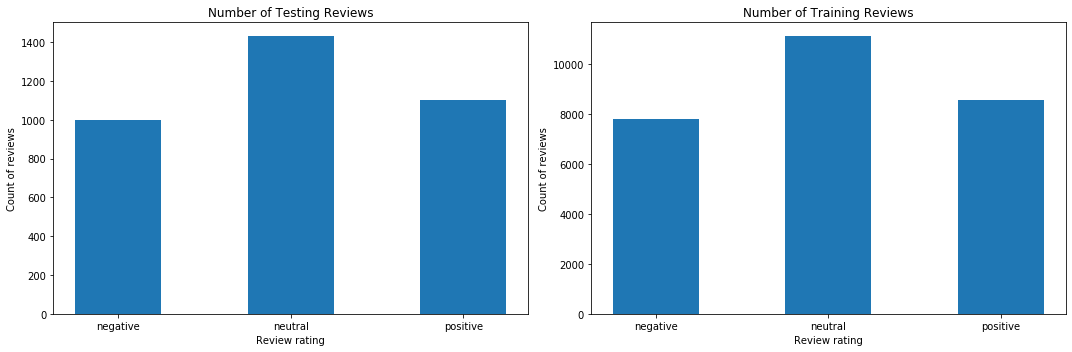

In [7]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

test_values, test_counts = np.unique(test['sentiment'], return_counts = True)
ax[0].bar(test_values, test_counts, width = 0.5)
ax[0].set_xlabel('Review rating')
ax[0].set_ylabel('Count of reviews')
ax[0].set_title('Number of Testing Reviews')


train_values, train_counts = np.unique(train['sentiment'], return_counts = True)
ax[1].bar(train_values, train_counts, width = 0.5)
ax[1].set_xlabel('Review rating')
ax[1].set_ylabel('Count of reviews')
ax[1].set_title('Number of Training Reviews')

plt.tight_layout()

In [8]:
train['sentiment'] = train['sentiment'].map({"negative":0, "neutral":1, 'positive':2})
train.head(5)

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2


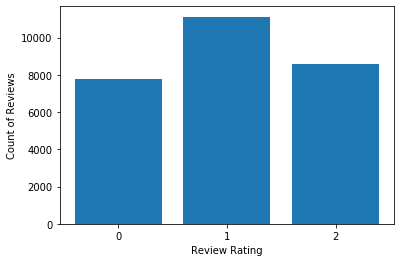

In [9]:
values, counts = np.unique(train['sentiment'], return_counts=True)
plt.figure()
plt.bar(["0","1",'2'], counts)
plt.xlabel('Review Rating')
plt.ylabel('Count of Reviews')
plt.show()

In [10]:
print(counts/np.sum(counts))

[0.28328179 0.40447517 0.31224304]


In [11]:
train

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2
...,...,...,...,...
27480,3dbae74fcd,"I want to go to VP, but no one is willing to c...","I want to go to VP, but no one is willing to c...",1
27481,63147b35cb,"Wah, why are you sad?","Wah, why are you sad?",1
27482,bdb196a09f,playing sudoku while mommy makes me breakfast ...,playing sudoku while mommy makes me breakfast ...,1
27483,18c2a1e98e,see u bye see u! i love the hot30,i love,2


# Cleaning

In [12]:
text = train["text"][1353]
text

'_mraz http://twitpic.com/4iq19 - popcorn crazy dude and still adorable'

In [13]:
def clean_text(text_colmuns):
    texts = []

    for text in text_colmuns:
        
        text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", text)
        text = text.lower()
        text = re.sub('[%s]'%re.escape(string.punctuation),'',text)
        text = re.sub(r'\d', '', text)  
    
        doc = nlp(text)
    
        tokens = [tok.lemma_.strip() for tok in doc]
        tokens = [tok for tok in tokens if tok != '']
        tokens = [tok for tok in tokens if tok != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stop_words]
        tokens = [tok for tok in tokens if len(tok) > 2]
        tokens = ' '.join(tokens)
        texts.append(tokens)

    return(texts)

In [14]:
train["clean_text"] = clean_text(train["text"])

# TF-IDF Vectorization

In [15]:
neg_text = [text for text in train[train['sentiment'] == 0]['clean_text']]

net_text = [text for text in train[train['sentiment'] == 1]['clean_text']]

pos_text = [text for text in train[train['sentiment'] == 2]['clean_text']]

# Negative Text

In [41]:
neg_tfidf = TfidfVectorizer().fit(neg_text)

neg_X_train = neg_tfidf.transform(neg_text)
neg_my_df = pd.DataFrame(columns=neg_tfidf.get_feature_names(), data=neg_X_train.toarray())
display(neg_my_df.head(1))

,aaaa,aaaaaaaaaahhhhhhhh,aaaaarrrrggghhh,aaaaawwwwwww,aaaagggessss,aaaagh,aaaah,aaaaw,aaahhh,aaargh,aaarrrgh,aaawww,aah,aargh,aaron,aarrgghh,aba,abandon,abandonment,abang,abbreviate,abby,abc,abean,abhor,abide,ability,abit,able,abnormal,abouttttto,abroadquot,abs,absolutely,absolutley,absolutly,abstraction,abt,abuelo,abuse,abusive,abusivementally,abuzz,aby,acaban,academic,academically,academyish,accadentally,accdentt,...,yukky,yum,yummmm,yummy,yumyum,yuotube,yup,yupunfortunately,yur,yuu,yyyyuck,zaboo,zach,zahedan,zealand,zemote,zemotecom,zenh,zenjar,zero,zindex,zip,zit,zoita,zombie,zone,zongzi,zoningconcept,zorny,zorzpeep,zotz,zuccini,zumba,zyrtec,zzzz,zzzzy,zzzzzzzzzzzzzzz,½iï,½m,½nadaï,½neleg,½net,½re,½rio,½s,½t,½timo,½ve,½you,½ï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
neg_word_counts = np.array(np.sum(neg_X_train, axis=0)).reshape((-1,))
neg_words = np.array(neg_tfidf.get_feature_names())
neg_words_df = pd.DataFrame({"word":neg_words,"count":neg_word_counts})
neg_plot = neg_words_df.sort_values(by="count", ascending=False).head(25)

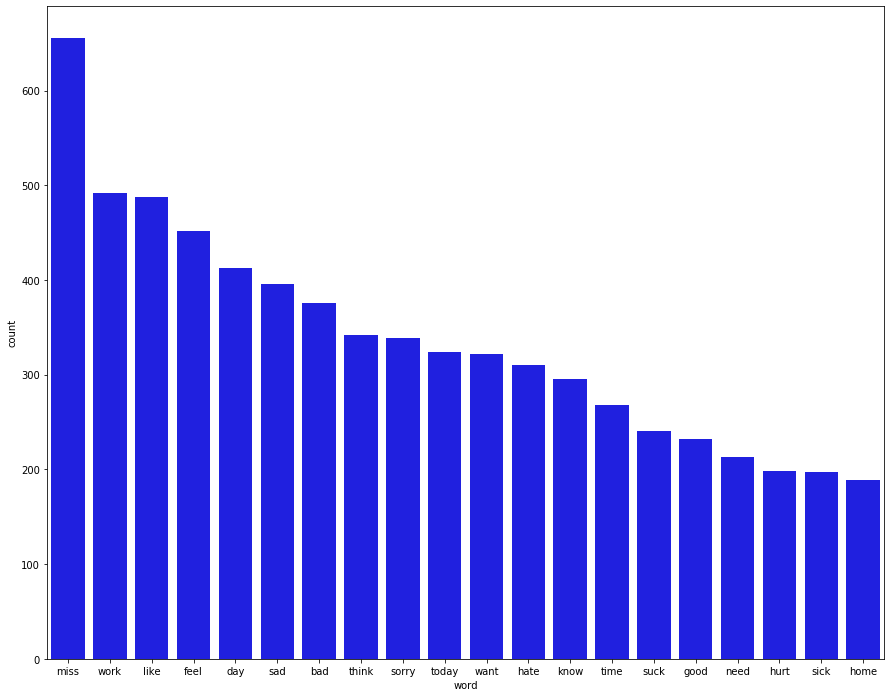

In [40]:
plt.figure(figsize=(15, 12))
sns.barplot(x = neg_plot['word'].head(20), y = neg_plot['count'].head(20),color='blue')

plt.show()

# Positive Text

In [43]:
pos_tfidf = TfidfVectorizer().fit(pos_text)

pos_X_train = pos_tfidf.transform(pos_text)
pos_my_df = pd.DataFrame(columns=pos_tfidf.get_feature_names(), data=pos_X_train.toarray())
display(pos_my_df.head(1))

,aaaaaaaaaamaze,aaaaaaaafternoon,aaaaaalcohol,aaaaall,aaaaaoouoouoouu,aaaah,aaaahh,aaaau,aaah,aaahaha,aaahhh,aaahhhjust,aaand,aaaw,aaawww,aah,aampe,aapko,aaron,aasman,abalone,abba,abbey,abbster,abc,abhi,ability,abit,able,abo,aboard,aboutquot,abp,abs,absent,absolute,absolutely,absolutley,absolutly,absoulutley,abt,abueltia,abundantbless,academy,acc,accent,accept,access,accident,accomplish,...,yvonne,yyankee,yyyyyyyyyoooooooooouuuuu,zac,zaccie,zach,zachary,zack,zapatos,zbrush,zdbp,zealand,zeb,zelda,zenrelated,zero,zeropointit,zipcode,zoe,zoey,zojuist,zombie,zombiepix,zomg,zommgg,zone,zoo,zulu,zune,zzzz,zzzzzzzgoodnight,½a,½being,½cia,½everybody,½i,½isï,½ll,½ltermand,½m,½ng,½o,½re,½s,½t,½tearï,½ve,½you,½z,½ï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
pos_word_counts = np.array(np.sum(pos_X_train, axis=0)).reshape((-1,))
pos_words = np.array(pos_tfidf.get_feature_names())
pos_words_df = pd.DataFrame({"word":pos_words,"count":pos_word_counts})
pos_plot = pos_words_df.sort_values(by="count", ascending=False).head(25)

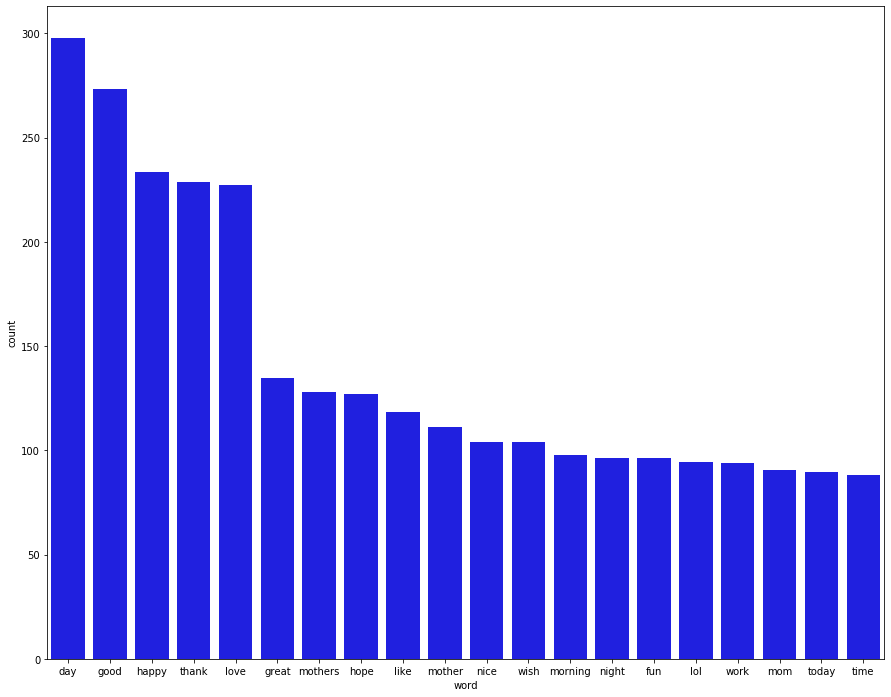

In [47]:
plt.figure(figsize=(15, 12))
sns.barplot(x = pos_plot['word'].head(20), y = pos_plot['count'].head(20),color='blue')
plt.show()

# Netural Text

In [48]:
net_tfidf = TfidfVectorizer().fit(net_text)

net_X_train = net_tfidf.transform(net_text)
net_my_df = pd.DataFrame(columns=net_tfidf.get_feature_names(), data=net_X_train.toarray())
display(net_my_df.head(1))

,aaa,aaaa,aaaaaaaaaaa,aaaaaaaahhhhhhhh,aaaaaah,aaaaaahhhhhhhh,aaaaaawwwesome,aaaaahhhh,aaaaandnothin,aaaaaw,aaaah,aaaand,aaaargh,aaaawww,aaah,aaahh,aaauuuggghhh,aaaw,aaaww,aac,aaggh,aah,aahhh,aampe,aannndd,aaron,aawww,ababa,abandon,abbey,abbie,abbreviation,abby,abc,abcd,abduct,aber,aberdeen,abi,ability,abit,able,ableton,aboutim,aboutquot,abrams,abroad,absence,absolutely,absolve,...,zoe,zoidberg,zol,zombie,zombiesquot,zone,zoo,zoom,zoombezi,zoozoo,zsg,zuljin,zulu,zuluxhosa,zum,zune,zwarte,zwitschert,zzzz,½a,½anisalovesu,½c,½en,½greedï,½guezs,½h,½jï,½l,½lle,½m,½mee,½mme,½n,½ndel,½ng,½o,½rdag,½re,½rlich,½s,½sseldorf,½sst,½stupidityï,½t,½ureo,½ve,½why,½whyyy,½y,½ï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
net_word_counts = np.array(np.sum(net_X_train, axis=0)).reshape((-1,))
net_words = np.array(net_tfidf.get_feature_names())
net_words_df = pd.DataFrame({"word":net_words,"count":net_word_counts})
net_plot = net_words_df.sort_values(by="count", ascending=False).head(25)

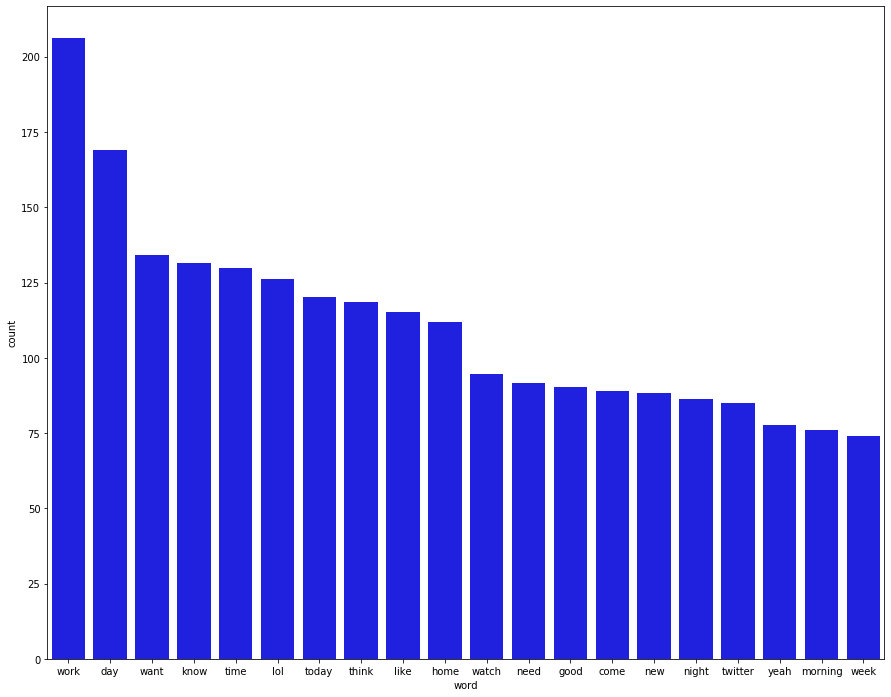

In [50]:
plt.figure(figsize=(15, 12))
sns.barplot(x = net_plot['word'].head(20), y = net_plot['count'].head(20),color='blue')
plt.show()

# Create Spooky Wordcloud